In [3]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical,normalize
from keras import backend as K
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import segmentation_models as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


Segmentation Models: using `keras` framework.


## Data Preprocessing

In [4]:
#importing the dataset

raw = pd.read_csv(r"C:\Users\renji\OneDrive\Desktop\test\imageclefcoral_training_2022_task_2.csv")

In [ ]:
#converting the co-ordinate points into list of lists

row_count = len(raw)
value1=[]

for i in range(0,row_count):
    value=[]
    value1.append(value)
    for j in range(4,918,2):
            col1 = raw.columns[j]
            col2 = raw.columns[j+1]
            a= [raw.loc[i,col1], raw.loc[i,col2]]
            value.append(a)

In [ ]:
# saving the processed dataset into excel file

v = pd.DataFrame(value1)
v.to_excel("converted-to-excel.xlsx")

## Creating the Masks

In [5]:
# loading the new datset and saving it as a pandas dataframe

point_data1 = pd.read_csv(r"C:\Users\renji\OneDrive\Desktop\test\imageclefcoral_training_2022_task_2 - Copy.csv")

In [6]:
point_data1.head()

,a1,a2,a3,a4,a5
0,2018_0714_112502_024,0,c_sponge_barrel,1,"[2037, 2648],[2114, 2567],[2231, 2434],[2231.0..."
1,2018_0714_112502_024,1,c_soft_coral_gorgonian,1,"[2639, 2283],[2668, 2404],[2631, 2517],[2639.0..."
2,2018_0714_112502_024,2,c_soft_coral,1,"[3834, 3008],[3834, 3008],[3712, 2941],[3668.0..."
3,2018_0714_112502_024,3,c_soft_coral,1,"[49, 1836],[150, 1766],[297, 1783],[267.0, 168..."
4,2018_0714_112502_024,4,c_soft_coral,1,"[994, 1838],[803, 1685],[614, 1534],[614.0, 15..."


In [7]:
#counting the co ordinate points againts each substrate class
point_data1['a3'].value_counts()

c_soft_coral               7745
c_hard_coral_boulder       7355
c_sponge                   6077
c_hard_coral_branching     3112
c_hard_coral_submassive    2618
c_algae_macro_or_leaves    1867
c_hard_coral_table          920
c_sponge_barrel             606
c_hard_coral_encrusting     380
c_hard_coral_mushroom       335
c_hard_coral_foliose        233
c_soft_coral_gorgonian      169
Name: a3, dtype: int64

In [8]:
# saving the co-ordinate points into seperate variable

co_ordinate1 = point_data1['a5']

In [ ]:
#assigning hues values to different classes

hues = {'c_soft_coral': 20,
        'c_hard_coral_submassive': 0,
        'c_hard_coral_mushroom': 40,
        'c_hard_coral_boulder': 60,
       'c_hard_coral_encrusting':80,
        'c_hard_coral_branching':100,
        'c_sponge_barrel': 90,
        'c_algae_macro_or_leaves': 50,
        'c_sponge': 110,
        'c_hard_coral_foliose':120,
        'c_soft_coral_gorgonian':130,
        'c_hard_coral_table':10
       }


In [ ]:
# Creating the mask images

path = glob.glob(r"C:\Users\renji\OneDrive\Desktop\test\test images\*.jpg")

for file in path:
    '''reading the images in the folder'''
    img= cv2.imread(file)
    
    im=str(Path(file).stem)
    
    '''fetching class values corresponding to co-ordinate points'''
    cord_pts = point_data1.loc[point_data1['a1'] == ("{}". format(im)), 'a5']
    cord_pts2 = point_data1.loc[point_data1['a1'] == ("{}". format(im)), 'a3']
    df_1 = pd.DataFrame(cord_pts2)
    df_2 = pd.DataFrame(cord_pts)
    df_new = pd.concat([df_1, df_2], axis=1)
    
    '''converting the coordinates into numpy array'''
    co_ordinates = (df_new['a5'])
    sub_class = (df_new['a3'])
    ints = [eval(x) for x in co_ordinates]
    pt =np.array([np.array(x,dtype=np.int32) for x in ints])
    #print(df_1)
    
    '''creating the blank image with the same shape as the input image'''
    blank = np.zeros(shape=img.shape, dtype=np.uint8)
    
    '''creating the mask images'''
    for i,j in zip(pt,sub_class):
        hue_value = hues.get(j)
        img= cv2.fillPoly(blank,[i],(hue_value,255,255))
        img_mask = cv2.cvtColor(blank, cv2.COLOR_HSV2RGB)
        image_path = r"C:\Users\renji\OneDrive\Desktop\annoted image.tif"
        filename = (''+str(im)+'.tif')
        final_path = os.path.join(image_path, filename)
        #plt.imshow(img_mask)
        '''saving the masked images in seperte folder'''
        status = cv2.imwrite(final_path,img_mask)
        print(filename," written to file-system : ",status)

## DeepLabV3+

Architecture Reference: https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/deeplabv3plus.py

In [107]:
'''squeeze and excite network'''
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

'''aspp module'''

def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

     """ Decoder """
    
    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(13, kernel_size=(1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x)
    return model
    #return x.shape

## Preparing the data for training

In [17]:
#reading the train and mask images and converting it in to numpy array

train_images = []
mask_images  = []

image_path = glob.glob(r"C:\Users\renji\OneDrive\Desktop\Datasets\K1-20180712-01\image data/*.JPG")
mask_path = glob.glob(r"C:\Users\renji\OneDrive\Desktop\Datasets\K1-20180712-01\mask/*.tif")

'''sorting the images in both mask and train image folder'''
mask_path.sort()
image_path.sort()

'''reading the train images using OpenCv'''
for train_image in image_path:
    img= cv2.imread(train_image,cv2.IMREAD_UNCHANGED)
    '''enhancing the image using bilateral filter'''
    img =cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    '''re-sizing the image'''
    img = cv2.resize(img, (image_size_Y, image_size_X))
    
    train_images.append(img)
train_images = np.array(train_images)    

for mask_image in mask_path:
    mask= cv2.imread(mask_image,cv2.IMREAD_UNCHANGED)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    '''re-sizing the image'''
    mask = cv2.resize(mask, (image_size_Y, image_size_X), interpolation = cv2.INTER_NEAREST)
    mask_images.append(mask)
'''coverting the mask into numpy array'''        
mask_images = np.array(mask_images) 

print('Train image_shape',train_images.shape)
print('Mask image_shape',mask_images.shape)


Train image_shape (50, 512, 512, 3)
Mask image_shape (50, 512, 512, 3)


In [18]:
#finding the unique RGB values in the masked images 

Unique_rgb_values=np.unique(np.array(mask_images).reshape(-1,3),axis=0)
Unique_rgb_values

array([[  0,   0,   0],
       [  0,   0, 255],
       [  0,  85, 255],
       [  0, 170, 255],
       [  0, 255,   0],
       [  0, 255,  84],
       [  0, 255, 169],
       [255,   0,   0],
       [255,   0,  85],
       [255,  84,   0],
       [255, 169,   0],
       [255, 254,   0]], dtype=uint8)

In [141]:
'''Assigning the mask image shapes to the labels'''
labels = mask_images[0]
labels.shape

(512, 512, 3)

In [142]:
#label encoding

def rgb_to_label(label):
   '''converting the RGB values into label values'''

    label_encode= np.zeros(labels.shape,dtype=np.uint8)
    
    label_encode [np.all(label == [0,0,0],axis=-1)]   = 0
    label_encode [np.all(label==[0,0,255],axis=-1)]   = 1
    label_encode [np.all(label==[0,170,255],axis=-1)] = 2
    label_encode [np.all(label==[0,255,0],axis=-1)]  = 3
    label_encode [np.all(label==[0,255,84],axis=-1)] = 4
    label_encode [np.all(label==[170,255,0],axis=-1)] = 5
    label_encode [np.all(label==[255,0,0],axis=-1)]   = 6
    label_encode [np.all(label==[0,85,255],axis=-1)]  = 7
    label_encode [np.all(label==[255,84,0],axis=-1)]  = 8
    label_encode [np.all(label==[255,169,0],axis=-1)] = 9
    label_encode [np.all(label==[255,254,0],axis=-1)] = 10
    label_encode [np.all(label==[ 0,255,169],axis=-1)] = 11
    label_encode [np.all(label==[ 255,0,85],axis=-1)] = 12
    

    
    label_encode = label_encode[:,:,0]
    
    return label_encode



In [144]:
#label encoding
'''finding the unique class labels and converting it into a numpy array'''
labels_Values = []
for i in range(mask_images.shape[0]):
    int_value = rgb_to_label(mask_images[i])
    labels_Values.append(int_value)    

labels_Values = np.array(labels_Values)   
labels_Values = np.expand_dims(labels_Values, axis=3)
print("Unique labels in label dataset are: ", np.unique(labels_Values))

Unique labels in label dataset are:  [ 0  3  4  5  8  9 10]


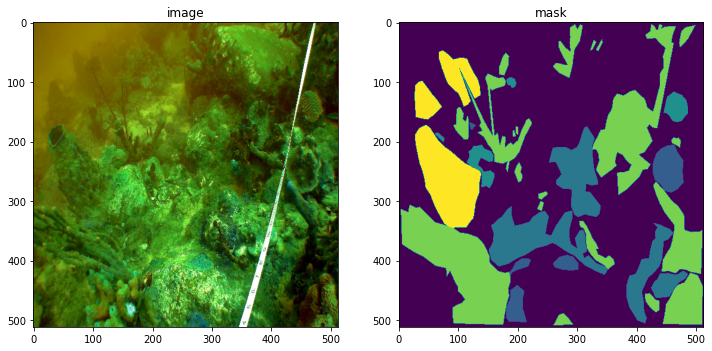

In [145]:
'''checking the train image against the mask 
                  to ensure the mask images are fetching against the 
                                            corresponding train images'''
import random
import numpy as np
image_number = random.randint(0, len(train_images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('image')
plt.imshow(train_images[image_number])
plt.subplot(122)
plt.title('mask')
plt.imshow(labels_Values[image_number][:,:,0])
plt.show()

## Training the Model

https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet

In [30]:
# finding individual class weights

weights = compute_class_weight('balanced', np.unique(np.ravel(labels_Values,order='C')), 
                               np.ravel(labels_Values,order='C'))
print('class weights are:',(weights))
weights_ = []
for i in weights:
    weights_.append(i)


class weights are: [1.97667901e-01 8.17861774e+00 1.46083545e+01 1.74315999e+00
 1.30810379e+04 5.66449028e+00]


In [31]:
#dice loss function:
dice_loss = sm.losses.DiceLoss(class_weights=weights)


In [146]:
#finding the number of classes in the entire dataset and converting it into catagorical values

n_classes = len(np.unique(labels_Values))
labels_Values
cat_values = to_categorical(labels_Values)
n_classes

7

In [147]:
cat_values.shape

(50, 512, 512, 11)

In [148]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(train_images, cat_values, test_size = 0.20, random_state = 42)

In [106]:
y_train.shape

(40, 512, 512, 13)

In [108]:
#fetching the model

h  = X_train.shape[1]
w  = X_train.shape[2]
channels  = X_train.shape[3]

def get_model():
    #return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=h, IMG_WIDTH=w, IMG_CHANNELS=channels)
    return deeplabv3_plus((512,512,3))
model = get_model()



In [109]:
#compiling the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

In [110]:
#training the model

history = model.fit(X_train, y_train, 
                    batch_size = 1, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    #class_weight=class_weight,
                    shuffle=False)


Epoch 1/20
40/40 [==============================] - 196s 5s/step - loss: 1.4359 - accuracy: 0.6430 - val_loss: 352.5548 - val_accuracy: 0.4740
Epoch 2/20
40/40 [==============================] - 194s 5s/step - loss: 0.9825 - accuracy: 0.7378 - val_loss: 1.7580 - val_accuracy: 0.4269
Epoch 3/20
40/40 [==============================] - 187s 5s/step - loss: 0.9021 - accuracy: 0.7481 - val_loss: 2.5351 - val_accuracy: 0.2581
Epoch 4/20
40/40 [==============================] - 188s 5s/step - loss: 0.8019 - accuracy: 0.7659 - val_loss: 2.4715 - val_accuracy: 0.3426
Epoch 5/20
40/40 [==============================] - 187s 5s/step - loss: 0.7001 - accuracy: 0.7955 - val_loss: 2.8700 - val_accuracy: 0.3632
Epoch 6/20
40/40 [==============================] - 187s 5s/step - loss: 0.6070 - accuracy: 0.8181 - val_loss: 2.3765 - val_accuracy: 0.3528
Epoch 7/20
40/40 [==============================] - 186s 5s/step - loss: 0.4878 - accuracy: 0.8546 - val_loss: 3.1274 - val_accuracy: 0.3900
Epoch 8/20


model.save(r"C:\Users\renji\OneDrive\Desktop\midjourney\gray scale mask\MASK_20epochs\.h5")

In [149]:
#prediction using the trained model

y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 12s 12s/step


In [ ]:
#calculating the Mean IoU values for individual test images

n_classes = 13
IOU_keras = MeanIoU(num_classes=n_classes) 
for i in range(0,10):
    IOU_keras.update_state(y_test_argmax[i], y_pred_argmax[i])
    print( IOU_keras.result().numpy())

In [ ]:
# Mean IOU for entire test image set

from keras.metrics import MeanIoU
n_classes = 13
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step


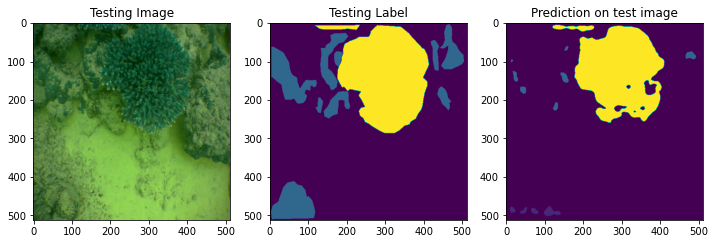

In [36]:
#prediction made on test image and plotting the output image

import random
test_img_number = random.randint(0,len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img.shape

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Data Augmentation

In [2]:
#craeting the data generator for augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    validation_split=0.1,fill_mode = 'constant')



In [40]:
#training the model using augmented images

model.fit(datagen.flow(X_train, y_train, batch_size=1,
         subset='training'),
         validation_data=datagen.flow(X_train, y_train,
         batch_size=8, subset='validation'), epochs=3)

Epoch 1/3
36/36 [==============================] - 183s 5s/step - loss: 0.8517 - accuracy: 0.7779 - val_loss: 1.7884 - val_accuracy: 0.4014
Epoch 2/3
36/36 [==============================] - 176s 5s/step - loss: 0.6034 - accuracy: 0.8389 - val_loss: 223.2349 - val_accuracy: 0.8717
Epoch 3/3
36/36 [==============================] - 182s 5s/step - loss: 0.5954 - accuracy: 0.8396 - val_loss: 5.4267 - val_accuracy: 0.8649


In [48]:
#saving the model
model.save(r"C:\Users\renji\OneDrive\Desktop\midjourney\gray scale mask\model_deeplab_20epochs\.h5")

1/1 [==============================] - 1s 754ms/step


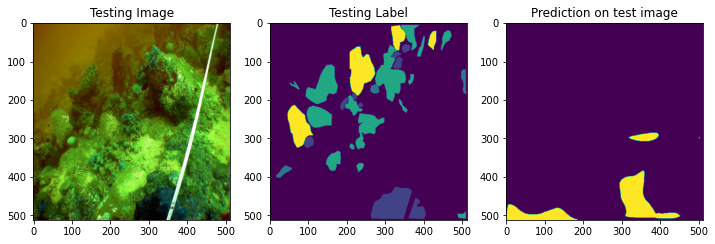

In [42]:
#prediction made on test image and plotting the output image

import random
#test_img_number = random.randint(0,len(X_test))
test_img_number = 0
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predicted_img.shape

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [41]:
## Mean IOU
from keras.metrics import MeanIoU

y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 8s 8s/step
Mean IoU = 0.13889877
